In [1]:
import torch
import torch.distributions as dist
import time
import numpy as np
import matplotlib.pyplot as plt

from kumaraswamy import KumaraswamyStable
from simple_squashed_normal import TanhNormal

from config import FIGURES_DIR

# Timing for Reparameterized Sample Generation and Gradient Computation

TODO: Inspect gradient and likelihood implementation and remove unnecessary if/print statements!!!

In [2]:
# Function to time sampling
def time_sampling(distribution, num_samples, num_trials=15, warmup=5, seed=50):
    torch.manual_seed(seed)
    times = []
    for _ in range(num_trials + warmup):
        start = time.time()
        samples = distribution.sample((num_samples,))
        end = time.time()
        times.append(end - start)
    return np.mean(times[warmup:]), np.std(times[warmup:])

# Function to time gradient computation
def time_gradients(distribution, num_samples, num_trials=15, warmup=5, seed=50):
    times = []
    torch.manual_seed(seed)
    for _ in range(num_trials + warmup):
        samples = distribution.sample((num_samples,))
        samples.requires_grad = True
        start = time.time()
        samples.sum().backward()
        end = time.time()
        times.append(end - start)
    return np.mean(times[warmup:]), np.std(times[warmup:])

In [ ]:
""" 
distributions =  [r'$\mathcal{N}$', r'$\mathcal{CB}$', 'Beta', 'Concrete', 'KS', 'PyTorch KS']

### Reparameterized Samples and Gradients
mean_times_samples = np.array([0.10256222, 0.04117042, 0.7423869, 0.0803507, 0.08920329, 0.05667113])
mean_stds_samples = np.array([0.00176291, 0.00044402, 0.00074256, 0.0006771, 0.00054105, 0.00074391])

mean_times_gradients = np.array([0.00203032, 0.00185609, 0.00253692, 0.00189848, 0.00189363, 0.00187704])
mean_stds_gradients = np.array([0.0001874, 0.00007955, 0.0000645, 0.00025979, 0.00005977, 0.00007903])

### Logpdf and Logpdf Gradients <-- currently ununsed
# mean time (s) for log pdf eval
log_pdf_means = np.array([0.028021, 0.15197,  0.193061, 0.111269, 0.088096, 0.115892])
log_pdf_stds = np.array([0.001295, 0.008347, 0.008229, 0.002421, 0.001784, 0.001222])

# mean time (s) for log pdf gradients
grad_means = np.array([0.012458, 0.007047, 0.019013, 0.07272,  0.124605, 0.1040126])"
""""

In [3]:
# Initialize distributions
temperature = torch.tensor([0.5])
concentration1 = torch.tensor([0.5])
concentration0 = torch.tensor([0.5])

distributions = {
    #'Gaussian': dist.Normal(loc=concentration1, scale=concentration0),
    r'$\mathcal{CB}$': dist.ContinuousBernoulli(probs=concentration1),
    #r'$\sigma_{\mathcal{N}}$': dist.LogisticNormal(loc=concentration1, scale=concentration0),
    r'$\tanh_{\mathcal{N}}$': TanhNormal(mu=concentration1, log_stdv=concentration0),
    'Beta': dist.Beta(concentration1, concentration0),
    #'Concrete': dist.RelaxedBernoulli(temperature, probs=concentration1),
    'KS': KumaraswamyStable(concentration1, concentration0),
    #'PyTorch KS': dist.Kumaraswamy(concentration1, concentration0)
}

num_samples = 10**7

# Collect data
data = {}
for name, distribution in distributions.items():
    sample_time_mean, sample_time_std = time_sampling(distribution, num_samples)
    grad_time_mean, grad_time_std = time_gradients(distribution, num_samples)
    data[name] = {
        'Sample Time Mean': sample_time_mean,
        'Sample Time Std': sample_time_std,
        'Gradient Time Mean': grad_time_mean,
        'Gradient Time Std': grad_time_std
    }

In [4]:
# Convert to numpy arrays for easy plotting
"""
sample_means = [data[name]['Sample Time Mean'] for name in distributions.keys()]
sample_stds = [data[name]['Sample Time Std'] for name in distributions.keys()]
grad_means = [data[name]['Gradient Time Mean'] for name in distributions.keys()]
grad_stds = [data[name]['Gradient Time Std'] for name in distributions.keys()]
labels = list(distributions.keys())
"""

"\nsample_means = [data[name]['Sample Time Mean'] for name in distributions.keys()]\nsample_stds = [data[name]['Sample Time Std'] for name in distributions.keys()]\ngrad_means = [data[name]['Gradient Time Mean'] for name in distributions.keys()]\ngrad_stds = [data[name]['Gradient Time Std'] for name in distributions.keys()]\nlabels = list(distributions.keys())\n"

In [5]:
# Convert to numpy arrays for easy plotting
sample_means = {name: data[name]['Sample Time Mean'] for name in distributions.keys()}
sample_stds = {name: data[name]['Sample Time Std'] for name in distributions.keys()}
grad_means = {name: data[name]['Gradient Time Mean'] for name in distributions.keys()}
grad_stds = {name: data[name]['Gradient Time Std'] for name in distributions.keys()}
labels = list(distributions.keys())

In [6]:
sample_means

{'$\\mathcal{CB}$': 0.042143599192301436,
 '$\\tanh_{\\mathcal{N}}$': 0.11684966087341309,
 'Beta': 0.7629620552062988,
 'KS': 0.0910438855489095}

In [7]:
# print 3 significant digits
np.set_printoptions(precision=8)
# turn off scientific notation
np.set_printoptions(suppress=True)
print(f'distributions', [s for s in distributions])
print(f'mean time (s) for samples', np.array(sample_means.values()))
print(f'mean stdv (s) for samples', np.array(sample_stds.values()), '\n')
print(f'mean time (s) for gradients', np.array(grad_means.values()))
print(f'mean stdv (s) for gradients', np.array(grad_stds.values()))
# turn off scientific notation

distributions ['$\\mathcal{CB}$', '$\\tanh_{\\mathcal{N}}$', 'Beta', 'KS']
mean time (s) for samples dict_values([0.042143599192301436, 0.11684966087341309, 0.7629620552062988, 0.0910438855489095])
mean stdv (s) for samples dict_values([0.0009252658951042829, 0.0022712179737661687, 0.003948317303296395, 0.0051554156333127234]) 

mean time (s) for gradients dict_values([0.001937103271484375, 0.0019971688588460287, 0.003457371393839518, 0.0020449479420979817])
mean stdv (s) for gradients dict_values([9.096840811697161e-05, 0.00011505598993607054, 0.0006609192738402059, 0.00012154920765342536])


In [8]:
distributions

{'$\\mathcal{CB}$': ContinuousBernoulli(probs: tensor([0.5000])),
 '$\\tanh_{\\mathcal{N}}$': TanhNormal(mu: tensor([0.5000]), log_stdv: tensor([0.5000]), low: -1.0, high: 1.0),
 'Beta': Beta(),
 'KS': KumaraswamyStable(log_concentration1: tensor([0.5000]), log_concentration0: tensor([0.5000]))}

In [9]:
# select subset and set order of distributions: Gaussian, Continuous Bernoulli, Beta, Concrete, KS, KS new
distributions = {k: distributions[k] for k in [r'$\mathcal{CB}$', r'$\tanh_{\mathcal{N}}$', 'Beta', 'KS']} #, r'$\sigma_{\mathcal{N}}$', 'PyTorch KS']}

distribution_names = [name for name in distributions.keys()]

def extract_list(data, distribution_names):
    return [data[name] for name in distribution_names]

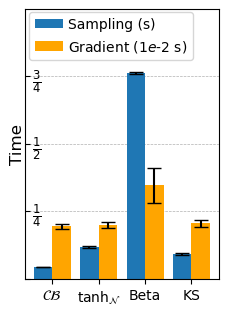

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming distribution_names, sample_means, sample_stds, grad_means, grad_stds are defined elsewhere

# Parameters
bar_width = 0.1  # Width of the bars
spacing = 0.15  # Space between the bars of separate distributions

yticklabel_pad = -12
fontsize_ticks = 12  # Font size for y-tick labels

# Number of distributions
n_distributions = len(distribution_names)

# X locations for the groups
x = np.arange(n_distributions) * (bar_width + spacing)

# Create a single subplot
fig, ax = plt.subplots(figsize=(2.5, 3.5))

# Set grid lines behind the bars
ax.set_axisbelow(True)

# Sampling bars
rects1 = ax.bar(x - bar_width/2, 
                extract_list(sample_means, distribution_names), 
                bar_width, label=r'Sampling (s)', 
                yerr=extract_list(sample_stds, distribution_names), 
                capsize=5)

# Gradient computation bars (scaled to 1e-2)
rects2 = ax.bar(x + bar_width/2, 
                1e2 * np.array(extract_list(grad_means, distribution_names)),  # Scale to 1e-2
                bar_width, label=r'Gradient ($1e$-$2$ s)', 
                yerr=1e2 * np.array(extract_list(grad_stds, distribution_names)),  # Scale to 1e-2
                capsize=5, color='orange')

# Labels and ticks
ax.set_xticks(x)
ax.set_xticklabels(distribution_names, rotation=0)

# Set y-axis limits and labels to accommodate both bars
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75])
ax.set_yticklabels(['', r'$\frac{1}{4}$', r'$\frac{1}{2}$', r'$\frac{3}{4}$'], fontsize=fontsize_ticks)
ax.tick_params(axis='y', direction='in', pad=yticklabel_pad)  # Move ticks inside

# Adding grid
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Manually set the legend location with adjusted spacing
ax.legend(loc='upper left', bbox_to_anchor=(0.00, 1.005), fontsize=10, ncol=1, 
          handletextpad=0.4, columnspacing=0.5, borderaxespad=0.3)

# Add the title shifted down by 10 units
ax.set_ylabel('Time', fontsize=12, labelpad=0)

# Save the figure
#plt.savefig(FIGURES_DIR + 'sampling_gradient_timing.png', bbox_inches='tight', pad_inches=0.01, dpi=200)

# Show the plot
plt.show()


# Timing for log-pdf evaluation and gradient computation

In [147]:
import torch
import torch.distributions as dist
import time
import numpy as np
import matplotlib.pyplot as plt

In [148]:
# Function to time log-pdf evaluation
def time_log_pdf(distribution, y, num_trials=15, warmup=5):
    times = []
    for _ in range(num_trials + warmup):
        start = time.time()
        log_probs = distribution.log_prob(y)
        end = time.time()
        times.append(end - start)
    return np.mean(times[warmup:]), np.std(times[warmup:])

# Function to time gradient computation of log-pdf
def time_log_pdf_gradients(distribution, y, num_trials=15, warmup=5):
    times = []
    for _ in range(num_trials + warmup):
        y.requires_grad = True
        log_probs = distribution.log_prob(y)
        start = time.time()
        log_probs.sum().backward()
        end = time.time()
        times.append(end - start)
        y.grad = None
    return np.mean(times[warmup:]), np.std(times[warmup:])

# Initialize distributions
batch_size = 10**7
output_size = 1  # Can be adjusted based on the specific problem

# seed
torch.manual_seed(100)

# Simulate output from an encoder and observed data
params = torch.rand(batch_size, output_size)
y = torch.rand(batch_size, output_size)

# Define the parameter ranges for Beta distribution ensuring they are positive
concentration1 = torch.rand(batch_size, output_size) + 0.1  # Adding 0.1 to avoid zero values
concentration0 = torch.rand(batch_size, output_size) + 0.1

# Create instances of distributions
distributions = {
    'Gaussian': dist.Normal(loc=params, scale=(params + 0.1) * 10**2),
    'Contin. Bern.': dist.ContinuousBernoulli(probs=params),
    'Beta': dist.Beta(concentration1, concentration0),
    'Concrete': dist.RelaxedBernoulli(temperature=params, probs=params),
    'KS': KumaraswamyStable(concentration1, concentration0),
    'PyTorch KS': dist.Kumaraswamy(concentration1, concentration0)
}

# Collect data
data = {}
for name, distribution in distributions.items():
    log_pdf_time_mean, log_pdf_time_std = time_log_pdf(distribution, y)
    grad_time_mean, grad_time_std = time_log_pdf_gradients(distribution, y)
    data[name] = {
        'Log PDF Time Mean': log_pdf_time_mean,
        'Log PDF Time Std': log_pdf_time_std,
        'Gradient Time Mean': grad_time_mean,
        'Gradient Time Std': grad_time_std
    }


In [149]:
# Convert to numpy arrays for easy plotting
log_pdf_means = [data[name]['Log PDF Time Mean'] for name in distributions.keys()]
log_pdf_stds = [data[name]['Log PDF Time Std'] for name in distributions.keys()]
grad_means = [data[name]['Gradient Time Mean'] for name in distributions.keys()]
grad_stds = [data[name]['Gradient Time Std'] for name in distributions.keys()]

In [150]:
# print 3 significant digits
np.set_printoptions(precision=6)
print(f'distributions', [s for s in distributions])
print(f'mean time (s) for log pdf evaluation', np.array(log_pdf_means))
print(f'mean stdv (s) for log pdf evaluation', np.array(log_pdf_stds), '\n')

print(f'mean time (s) for gradients', np.array(grad_means))
print(f'mean stdv (s) for gradients', np.array(grad_stds))
# turn off scientific notation

distributions ['Gaussian', 'Contin. Bern.', 'Beta', 'Concrete', 'KS', 'PyTorch KS']
mean time (s) for log pdf evaluation [0.028021 0.15197  0.193061 0.111269 0.088096 0.115892]
mean stdv (s) for log pdf evaluation [0.001295 0.008347 0.008229 0.002421 0.001784 0.001222] 

mean time (s) for gradients [0.012458 0.007047 0.019013 0.07272  0.124605 0.104012]
mean stdv (s) for gradients [0.000442 0.000477 0.000657 0.000566 0.000687 0.000606]


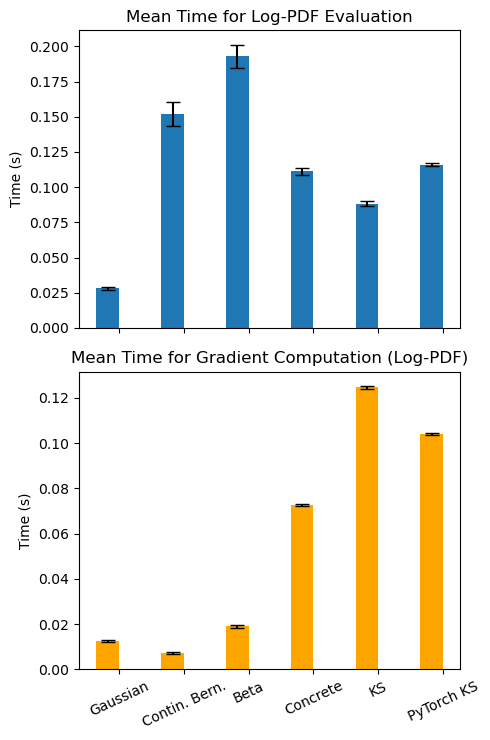

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Data
"""
distributions = ['Gaussian', 'Contin. Bern.', 'Beta', 'Concrete', 'KS', 'PyTorch KS']
# mean time (s) for log pdf eval
log_pdf_means = np.array([0.028021, 0.15197,  0.193061, 0.111269, 0.088096, 0.115892])
log_pdf_stds = np.array([0.001295, 0.008347, 0.008229, 0.002421, 0.001784, 0.001222])

# mean time (s) for log pdf gradients
grad_means = np.array([0.012458, 0.007047, 0.019013, 0.07272,  0.124605, 0.1040126])
grad_stds = np.array([0.000442, 0.000477, 0.000657, 0.000566, 0.000687, 0.000606])
"""

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(5, 7.5), sharex=True)

x = np.arange(len(distributions))
width = 0.35

# Sampling time
i = 0
axs[i].bar(x - width/2, log_pdf_means, width, yerr=log_pdf_stds, capsize=5)
axs[i].set_ylabel('Time (s)')
axs[i].set_title('Mean Time for Log-PDF Evaluation')

# Gradient computation time for samples
i += 1
axs[i].bar(x - width/2, grad_means, width, yerr=grad_stds, capsize=5, color='orange')
axs[i].set_ylabel('Time (s)')
axs[i].set_title('Mean Time for Gradient Computation (Log-PDF)')

"""
# Log-PDF evaluation time
i += 1
axs[i].bar(x - width/2, mean_time_logpdf, width, yerr=stdv_time_logpdf, capsize=5, label='Log-PDF Evaluation Time')
axs[i].set_ylabel('Time (s)')
axs[i].set_title('Mean Time for Log-PDF Evaluation')
axs[i].legend()

# Gradient computation time for log-PDF
i += 1
axs[i].bar(x - width/2, mean_time_logpdf_gradients, width, yerr=stdv_time_logpdf_gradients, capsize=5, label='Gradient Time for Log-PDF')
axs[i].set_ylabel('Time (s)')
axs[i].set_title('Mean Time for Gradient Computation (Log-PDF)')
axs[i].legend()
"""


# Set x-ticks and labels
plt.xticks(x, distributions, rotation=25)
#axs[i].set_xlabel('Distributions')

# Adjust layout
plt.tight_layout()
plt.show()
